In [2]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Multiply, Reshape, GlobalMaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from PIL import Image



# 1. SE Block definition

In [3]:
def se_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    x = Multiply()([input_tensor, se])
    return x

# 2. Data Preparation

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
    'train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    'val',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 6507 images belonging to 102 classes.
Found 1682 images belonging to 102 classes.


# 3. Model with DenseNet201 + SE block

In [5]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = se_block(x)  # Apply SE block
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(102, activation='softmax')(x)

In [6]:
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Train the model

In [7]:
history = model.fit(training_set, epochs=5, validation_data=test_set)

Epoch 1/5
102/102 [==============================] - 739s 7s/step - loss: 1.9212 - accuracy: 0.5728 - val_loss: 0.6800 - val_accuracy: 0.8169
Epoch 2/5
102/102 [==============================] - 687s 7s/step - loss: 0.4838 - accuracy: 0.8744 - val_loss: 0.4458 - val_accuracy: 0.8805
Epoch 3/5
102/102 [==============================] - 680s 7s/step - loss: 0.3110 - accuracy: 0.9184 - val_loss: 0.3216 - val_accuracy: 0.9102
Epoch 4/5
102/102 [==============================] - 701s 7s/step - loss: 0.2171 - accuracy: 0.9425 - val_loss: 0.3206 - val_accuracy: 0.9150
Epoch 5/5
102/102 [==============================] - 706s 7s/step - loss: 0.1776 - accuracy: 0.9521 - val_loss: 0.3072 - val_accuracy: 0.9138


# 5. Evaluation and Metrics

In [10]:
loss, accuracy = model.evaluate(test_set)

print(f"\nValidation Accuracy: {accuracy * 100:.2f}%")

27/27 [==============================] - 138s 5s/step - loss: 0.3072 - accuracy: 0.9138

Validation Accuracy: 91.38%


# Predictions

In [11]:
y_pred = model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set.classes
class_labels = list(test_set.class_indices.keys())

27/27 [==============================] - 143s 5s/step


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


Precision: 0.9265
Recall:    0.9114
F1-score:  0.9107


# Classification report

In [13]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

     label_1       1.00      0.75      0.86         8
    label_10       1.00      1.00      1.00         9
   label_100       1.00      1.00      1.00        10
   label_101       0.85      0.92      0.88        12
   label_102       1.00      1.00      1.00        10
    label_11       0.86      0.67      0.75        18
    label_12       0.94      0.94      0.94        18
    label_13       1.00      0.80      0.89        10
    label_14       1.00      0.70      0.82        10
    label_15       1.00      0.90      0.95        10
    label_16       0.60      1.00      0.75         9
    label_17       0.94      1.00      0.97        17
    label_18       1.00      0.82      0.90        17
    label_19       0.62      0.80      0.70        10
     label_2       1.00      1.00      1.00        12
    label_20       1.00      0.83      0.91        12
    label_21       1.00      1.00      1.00         8
   

# 6. Accuracy & Loss Graphs

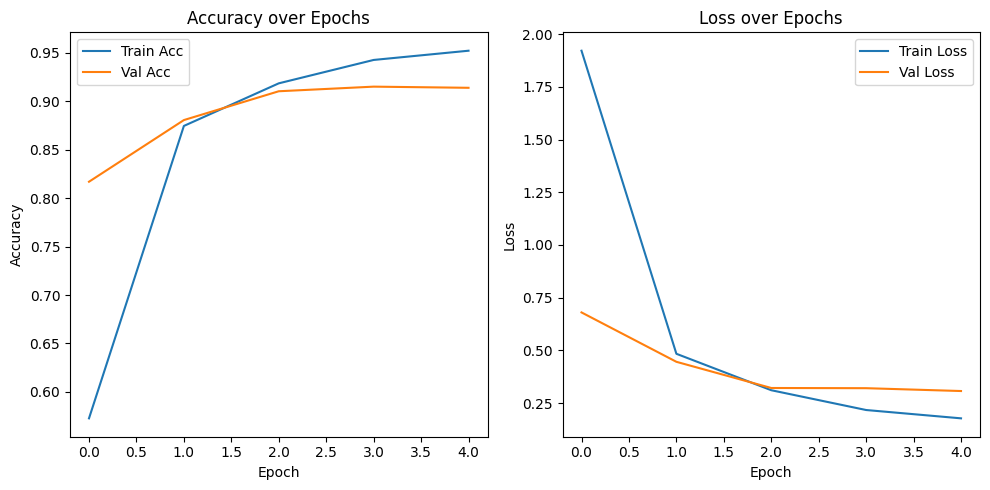

In [15]:
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# 7. Predict on Random Test Images

1/1 [==============================] - 5s 5s/step


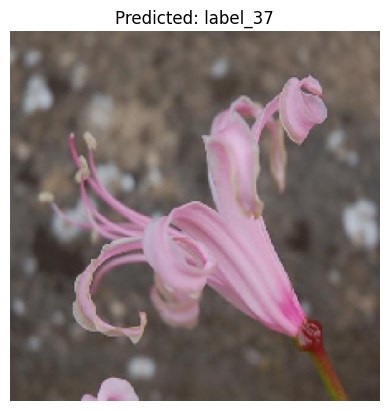

1/1 [==============================] - 0s 290ms/step


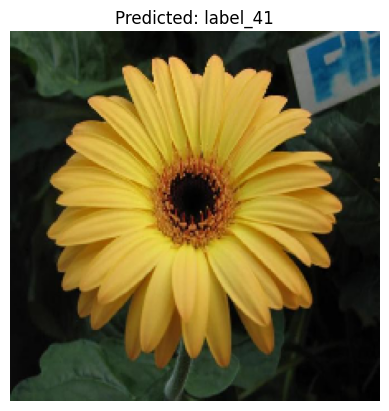

1/1 [==============================] - 0s 130ms/step


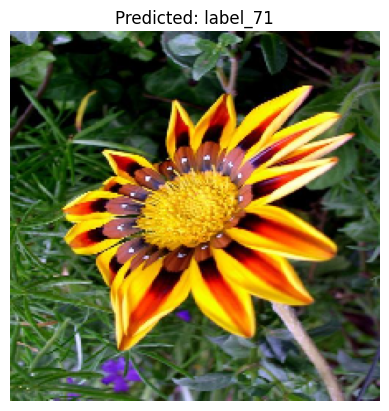

1/1 [==============================] - 0s 133ms/step


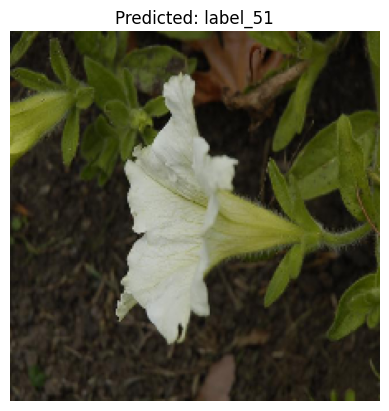

1/1 [==============================] - 0s 175ms/step


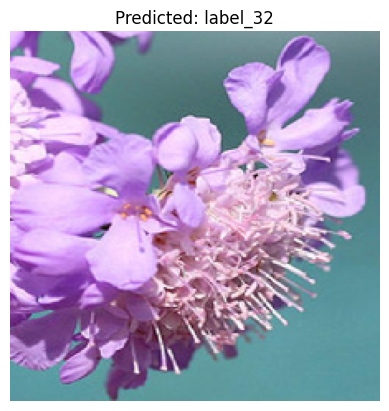

In [16]:
def show_random_predictions(model, dataset, class_labels):
    indices = random.sample(range(len(dataset.filenames)), 5)
    for i in indices:
        img_path = os.path.join(dataset.directory, dataset.filenames[i])
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        pred = model.predict(np.expand_dims(img_array, axis=0))
        predicted_class = class_labels[np.argmax(pred)]

        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class}")
        plt.axis('off')
        plt.show()

show_random_predictions(model, test_set, class_labels)